_Author: Dana Chermesh for Perl Street, Aug 2018_
# Hotel conversion to a Co-living project, Greenwich Village, NYC
### _27W 11th St, NY, NY_
## Motivation:
The goal of this project is to make first pass projection of the revenue and risks of a hotel located in Greenwich Village, NYC, being converted into 77 units co-living residential housing, using different public data sources. Assume that there is no construction risk. 

## Project Highlights:
- Unique NYC location in the heart of Greenwich Village steps away from Union Square, the West Village, the East Village, Soho and the Lower East Side
- Almost built to suit product with a kitchenette per every 7 bedrooms and large communal space on the basement level
- NYC has seen a tremendous rise in the number of co-living building but this is uniquely positioned within the city 

### Gross Area: Approximately 24,000 sf

### # of Units: 77 Co-Living Units

### Listing Date: August 1st 2018

### Communal Space Rations:
    1. 1 Small Kitchenette per 7 bedrooms
    2. 1 Bathroom per every 3.5 bedrooms
    3. 1 full size kitchen per 77 bedrooms
    4. 1 Lounge per 25 bedrooms
    5. 1 Open Space per 77 bedrooms
    6. 1 Laundry area per 77 bedrooms

----

# _Analysis steps:_
1. **Architectural aspect: Project mix and basic residential unit:**<br>
    Assess the size of a bedroom / a **basic residential unit** (== 7 bedrooms) in the project
2. **Time series analysis of comparable classic housing type for rental market in Greenwich Village neighbourhood**<br>
    Analyse the trend and make a prediction for 15 years.
3. Build a **housing-coliving rent ratio** based on _office-coworking rent ratio_
    Determine the first rent to be asked for a bedroom in the project.
4. Build a model to predict _Median Gross Rent_:
  - Explore the data using scatter matrix and pairplots
  - **Multivariate linear regression analysis** of census bureau data; compute: 
       - p-values
       - coefficients
       - model's feature importance
5. **Revenue and Risks** 
    - Predict **_asking rent for a bedroom_** over the next 15 years <br>
    - Assume vacancy rate to correct the projection

-----

# Imports

In [65]:
import pandas as pd
import numpy as np
import matplotlib.pylab as pl

import json
import requests 
import urllib
from pandas.tools.plotting import scatter_matrix

# OLS / ML assignments
import scipy as sp
# from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score, log_loss
# from scipy.spatial.distance import cdist, pdist
from scipy.cluster.vq import kmeans2, whiten
from sklearn import preprocessing
import statsmodels.formula.api as smf
import statsmodels.api as sm
from sklearn import metrics, cross_validation
# from sklearn import ensemble
from sklearn.model_selection import train_test_split
# from sklearn import svm
from sklearn import linear_model
# from sklearn.linear_model import LogisticRegression, RidgeClassifierCV

import seaborn as sns
sns.set_style('whitegrid')

%pylab inline

Populating the interactive namespace from numpy and matplotlib


----

# Data acquisition 

## 1. _Street Easy data for Multifamily rentals in Greenwich Village, 1-br and studios_

_**[Street Easy Data](https://streeteasy.com/blog/download-data/)**_. Data were aquired for multifamily rentals of 1-br and studios for Greenwich Village neighborhood. 

For direct download of zipped files:

   - [Inventory 1br](https://s3.amazonaws.com/streeteasy-market-data-api/data_repository/G1_rentalInventory_OneBd.zip)
   - [Inventory studio](https://s3.amazonaws.com/streeteasy-market-data-api/data_repository/F1_rentalInventory_Studio.zip)
   - [Median asking rent 1br](https://s3.amazonaws.com/streeteasy-market-data-api/data_repository/G2_medianAskingRent_OneBd.zip)
   - [Median asking rent studio](https://s3.amazonaws.com/streeteasy-market-data-api/data_repository/F2_medianAskingRent_Studio.zip)

In [66]:
DATA = "/../Users/danachermesh/Desktop/DataProjects/Co-living_Greenwich-Village_NYC/data"

In [67]:
# inventory 1br
inventory_1br = pd.read_csv(DATA + "/G1_rentalInventory_OneBd.csv").fillna(0)
inventory_1br = inventory_1br[inventory_1br["Area"] == "Greenwich Village"]

inventory_1br = inventory_1br.set_index("Area")
inventory_1br = inventory_1br.iloc[:,2:]
inventory_1br = inventory_1br.astype(int)
inventory_1br = inventory_1br.rename({'Greenwich Village': 'inv_1BR'})

# inventory studio
inventory_st = pd.read_csv(DATA + "/F1_rentalInventory_Studio.csv").fillna(0)
inventory_st = inventory_st[inventory_st["Area"] == "Greenwich Village"]

inventory_st = inventory_st.set_index("Area")
inventory_st = inventory_st.iloc[:,2:]
inventory_st = inventory_st.astype(int)
inventory_st = inventory_st.rename({'Greenwich Village': 'inv_Studio'})

# Median rent 1br
MedianRent_1br = pd.read_csv(DATA + "/G2_medianAskingRent_OneBd.csv").fillna(0)
MedianRent_1br = MedianRent_1br[MedianRent_1br["Area"] == "Greenwich Village"]

MedianRent_1br = MedianRent_1br.set_index("Area")
MedianRent_1br = MedianRent_1br.iloc[:,2:]
MedianRent_1br = MedianRent_1br.astype(int)
MedianRent_1br = MedianRent_1br.rename({'Greenwich Village': 'MedRent_1BR'})

# Median rent studio
MedianRent_studio = pd.read_csv(DATA + "/F2_medianAskingRent_Studio.csv").fillna(0)
MedianRent_studio = MedianRent_studio[MedianRent_studio["Area"] == "Greenwich Village"]

MedianRent_studio = MedianRent_studio.set_index("Area")
MedianRent_studio = MedianRent_studio.iloc[:,2:]
MedianRent_studio = MedianRent_studio.astype(int)
MedianRent_studio = MedianRent_studio.rename({'Greenwich Village': 'MedRent_Studio'})

GW_rentals = MedianRent_1br.append([MedianRent_studio, inventory_1br, inventory_st])

print(GW_rentals.shape)
GW_rentals

(4, 102)


,2010-01,2010-02,2010-03,2010-04,2010-05,2010-06,2010-07,2010-08,2010-09,2010-10,...,2017-09,2017-10,2017-11,2017-12,2018-01,2018-02,2018-03,2018-04,2018-05,2018-06
Area,,,,,,,,,,,,,,,,,,,,,
MedRent_1BR,3175,3200,2997,3000,3000,3250,3000,3000,3650,3725,...,3600,3662,3662,3695,3600,3750,3650,3750,3450,3695
MedRent_Studio,2100,2100,2000,2000,2190,2100,2037,2087,2472,2600,...,2725,2750,2687,2600,2646,2615,2697,2750,2700,2685
inv_1BR,164,196,194,214,222,223,188,184,133,136,...,223,228,196,178,189,177,183,213,197,209
inv_Studio,101,111,134,133,162,165,150,136,76,71,...,108,111,108,97,107,94,102,107,112,116


## 2. _Census Bureau Data_ for predicting median rent
_**American Community Survey (ACS) 5-years estimates for years 2012-2016**, NYC five boroughs on the census tract level._

- [Variables](https://api.census.gov/data/2016/acs/acs5/variables.html)
- [Examples](https://api.census.gov/data/2016/acs/acs5/examples.html)

- Get a Census API key at: https://api.census.gov/data/key_signup.html

### Scope and Assumptions:
- Data were obtained only for the **ACS 5-year estimates of 2012-2016**. 
- Data were obtained for NYC five boroughs, in order to get a big enough sample. However, in a deeper analysis I would rather build my dataset from aggregation of cities / areas (places) similar to Manhattan or Greenwich Village in particular, and / or that are approximate to University places across the US. 
- Using grabularity level of _block groups_ instead of _census tracts_should be considered in a further research.

- Population density would be a better factor to use than Total Population. Area data needed (shapefiles); available via Tiger.Line tools.
- In a further research I would obtain data for 2010 also (*), will calcilate the _change_ of each variables over time and will use the change variables for the regressors and for the target variable (rent change) as well. 

**(*) when obtaining 2010 data one should decide between ACS 5-years estimates 2006-2010 or the decennial census 2010. The first option could be problematic because of the great recession (2008). Another option is to use data from 2000 to overcome the 2008 outliers.** 


Variables obtained for data of demographics + housing, including:
- Population
- Median income
- rented units % out of housing units stock
- Bachelor degree holders out of population
- vacancy rates

** In further analysis I would obtain a larger set of variables, then look for the 5-10 most important variables to build my final model. Some of these variables could be: age groups %, unemployment rates, marital status, population density, housing production by housing types, and more.

In [68]:
# reading in my api key saved in censusAPI.py as
# myAPI = 'XXXXXXXXXXXXXXX'
# request an api key in: https://api.census.gov/data/key_signup.html
from censusAPI import myAPI

In [69]:
#read in in the variables available. the info you need is in the 1year ACS data
url = "https://api.census.gov/data/2016/acs/acs5/variables.json"
resp = requests.request('GET', url)
aff1y = json.loads(resp.text)

In [70]:
#turning things into arrays to enable broadcasting
#Python3
affkeys = np.array(list(aff1y['variables'].keys()))

affkeys

array(['B17022_029E', 'B07404GPR_004E', 'C23002E_002E', ...,
       'B20005E_037E', 'B24012_045E', 'B17022_049E'], dtype='<U14')

In [71]:
# keyword for POP estimates
totalPop = 'B01003_001E'
income = 'B06011_001E'
bachelor = 'B15003_022E' # age 25 and over
totalHU = 'B25001_001E'
vac_forrent = 'B25004_002E'
vac_rented = 'B25004_003E'
renter = 'B25003_003E'

grossrent_0br = 'B25031_002E'
grossrent_1br = 'B25031_003E'

aff1y['variables'][vac_rented]

{'attributes': 'B25004_003M,B25004_003MA,B25004_003EA',
 'concept': 'VACANCY STATUS',
 'group': 'B25004',
 'label': 'Estimate!!Total!!Rented, not occupied',
 'limit': 0,
 'predicateType': 'int'}

In [72]:
# 2016 data for all census tracts in NYC
data16 = pd.read_json('https://api.census.gov/data/2016/acs/acs5?get='+
                         totalPop + ',' + 
                         income + ',' + 
                         bachelor + ',' +
                         totalHU + ',' +
                         vac_forrent + ',' +
                         vac_rented + ',' +
                         renter + ',' +
                         grossrent_0br + ',' +
                         grossrent_1br +',NAME&for=tract:*&in=state:36'\
                                        '&in=county:061,047,081,085,005')

data16.columns = data16.iloc[0]
data16 = data16.iloc[1:,:-4] # named tracts index is redundant in this case

data16.columns = ['totalPop', 'MedIncome', 'bachelor', 'totalHU', 
                  'vac_forrent', 'vac_rented', 'renter',
                  'grossrent_0br', 'grossrent_1br']

data16 = data16.astype(int)
data16 = data16[(data16 != 0).all(1)]

data16 = data16[data16['grossrent_0br'] > 0]
data16 = data16[data16['grossrent_1br'] > 0].reset_index()\
        .drop('index', axis=1)

print(data16.shape)
data16.head(3)

(327, 9)


,totalPop,MedIncome,bachelor,totalHU,vac_forrent,vac_rented,renter,grossrent_0br,grossrent_1br
0,6056,17848,211,2049,29,34,1665,550,653
1,9131,13258,491,3190,69,17,2497,399,638
2,6021,13915,244,2151,77,30,1841,663,708


### Data wrangling
- rented housing units % out of total housing units
- occupied % out of total housing units
- vacants % out of total housing units
- Average Gross rent for 0br + 1br

In [73]:
data16['bachelor_per'] = data16['bachelor']/data16['totalPop']
data16['rented_per'] = data16['renter']/data16['totalHU']
data16['vacants_rent_per'] = (data16['vac_forrent']+data16['vac_rented']) / data16['totalHU']

data16['Med_GrossRent'] = (data16['grossrent_0br']+data16['grossrent_1br'])/2

data16 = data16.drop(['bachelor', 'vac_forrent', 'vac_rented',
                      'renter', 'grossrent_0br', 'grossrent_1br'],
                       axis=1)

print(data16.shape)
data16.head()

(327, 7)


,totalPop,MedIncome,totalHU,bachelor_per,rented_per,vacants_rent_per,Med_GrossRent
0,6056,17848,2049,0.034841,0.812592,0.030747,601.5
1,9131,13258,3190,0.053773,0.782759,0.026959,518.5
2,6021,13915,2151,0.040525,0.855881,0.049744,685.5
3,5181,18604,1666,0.041112,0.823529,0.013205,1270.0
4,5687,15040,2038,0.036223,0.881256,0.035819,1043.0


### After cleaning the data, I have 327 data points. 


-----
# Analysis

# 1. Architectural aspect: project mix + basic residential unit size  
## Assess the size of a bedroom / a basic unit (== 7 bedrooms)

Given info + Assumptions: 
-	**24,000 sf** == **4000 sf * 6 stories** _(not including basement)_
-	A **_basic unit_** includes **7 bedrooms, 2 bathrooms, 1 small kitchenette**
- All basic units are identical.
- In total, there are **11 residential units** in the project.
-	**2 basic units in each story** for floors 2-6, **Lounge + 1 basic unit** in floor 1.
-	**Basement**: Open space, Full-size Kitchen, Laundry
-	Public area that is not included in the basic unit (stairs + elevators, technical systems, etc) is about **10% of a floor** >> leaving **3,600 sf for 2 basic units, 1,800 sf each**.
-	Each bedroom’s size is considered as the bedroom area + its share in the unit’s amenities, meaning the 2 bathrooms + kitchenette.


## Result: 
A **basic unit is _1,800 sf_**, each **bedroom is considered to be _255 sf_**. This size is similar to other coliving bedrooms in NYC, although the _ratio of bedroom-bathroom_ and _bedroom-kitchen_ is worse than most others:  **2 bathroom for every 7 bedrooms** compared to **private bathrooms to 2 bathrooms for every 3 bedrooms** (examples: [Ollie floor plans](https://altalic.com/wp-content/uploads/2018/08/ALTA-by-Ollie-804.png), [COMMON floor plans](http://cdn.brownstoner.com/wp-content/uploads/2015/10/Common-1162-Cellar1st-2nd-Floor-Construction-Plans-e1445273623967.jpg)). <br>**This might negatively affect the demand for the bedrooms and should be calculated into the risks and revenues prediction**.

![coliving_unit/](coliving_unit.png)

### Picture.1: Project Mix (left) and a suggested co-living basic unit of 7 bedrooms, 2 bathrooms and a kitchenette (right)
** _The plan is based on different plans of current co-housing in NYC, measurements are not accurate to the SF calculation above._

----
# 2. Time Series Analysis of comparable rental housing types' median asking rent 

### Approach: 
Analyse the neighborhood's rental housing market for multifamily, **1-br and studios apartments only**, as the classic housing type equivalent to a co-housing bedroom.

### Scope and Assumptions:
-	Street Easy is a reliable proxy for assessing housing market condition + demand.
-	Analysing the condition + trends of the specific neighborhood only.
-	The total inventories of 1-br and studios will be the base for weightening the two types median rents in order to assess an equivalent dwelling type for a co-living bedroom
- Median rent is more robust to outliers than Average rent (based on [Street Easy data reporting method](https://streeteasy.com/blog/download-data/))
-	Lacking longitudinal data on co-housing, the ratio of Office VS co-working equivalent space will be used as a proxy for assessing the rent ratio between co-living bedroom and its equivalent classic housing type.

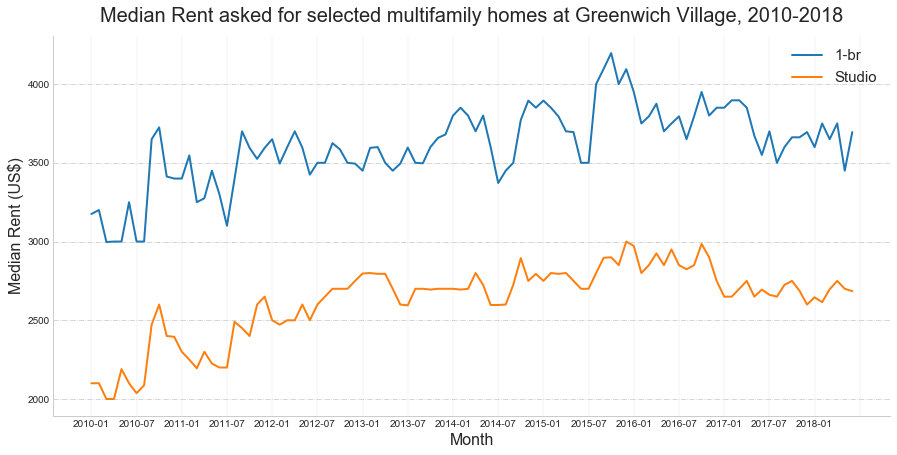

In [74]:
fig = pl.figure(figsize=(15,7))
ax = fig.add_subplot(111)

ax.plot(GW_rentals.T.iloc[:,:2], label=True, lw=2)
ax.set_title("Median Rent asked for selected multifamily homes at Greenwich Village, 2010-2018",
            fontsize=20, y=1.02)
ax.set_ylabel('Median Rent (US$)', fontsize=16)
ax.set_xlabel('Month', fontsize=16)

ax.grid(axis='y', linestyle='-.')
ax.grid(axis='x', lw=.2);
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.xaxis.set_major_locator(plt.MaxNLocator(20))
ax.legend(['1-br', 'Studio'], fontsize=15)

### Fig.1: 1-br and Studio rentals in Greenwich Village, Manhattan NYC from 2010/01 to 2018/06;
Both types of multifamily residential rentals seem to show similar trends; therefore I will average their prices, weighted by their total inventories, to assess the median rent ansked for the relevant market. This price will be used as a base for the co-living rent asking in the same area.

** _In a further research, I would analyse both housing types trends and stationarity, to make sure they perform similarly._

In [75]:
GW_allrent = GW_rentals.T

GW_allrent['GV_medRent'] = (GW_allrent['MedRent_1BR']*GW_allrent['inv_1BR'] + 
                            GW_allrent['MedRent_Studio']*GW_allrent['inv_Studio']) / \
                            (GW_allrent['inv_1BR'] + GW_allrent['inv_Studio'])

GW_allrent = GW_allrent.iloc[:,-1:]
GW_allrent = GW_allrent.round(0).astype(int)

GW_allrent.head()

Area,GV_medRent
2010-01,2765
2010-02,2802
2010-03,2590
2010-04,2617
2010-05,2658


In [99]:
GW_allrent.tail(2)

Area,GV_medRent
2018-05,3178
2018-06,3335


### The last inventory of the data (June 2018) shows the median asking rent for comparable rental housing types in Greenwich Village was 3,335 US Dollars.

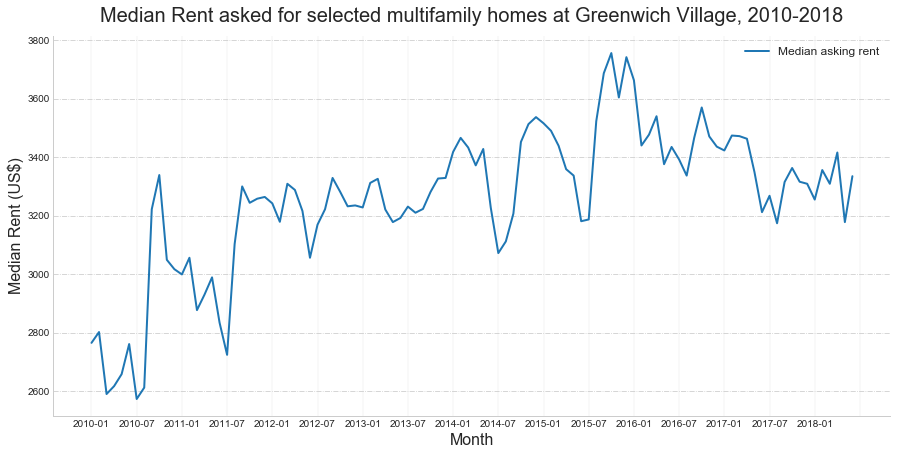

In [76]:
fig = pl.figure(figsize=(15,7))
ax = fig.add_subplot(111)

ax.plot(GW_allrent.iloc[:,-1:], label='Median asking rent', lw=2)

ax.set_title("Median Rent asked for selected multifamily homes at Greenwich Village, 2010-2018",
            fontsize=20, y=1.02)
ax.set_ylabel('Median Rent (US$)', fontsize=16)
ax.set_xlabel('Month', fontsize=16)

ax.grid(axis='y', linestyle='-.');
ax.grid(axis='x', lw=.2)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.xaxis.set_major_locator(plt.MaxNLocator(20))
ax.legend(fontsize=12)

### Fig.2: Median asking rent for multifamily homes at Greenwich Village, Manhattan, NYC, 2010/01-2018/06, studios+1-br only (weighted average)
The longitudinal line shows fluctuation in the rent, although overall we can say the Greenwich Village rentals for 1-br and studios housing market is growing from mid-2010 to the begining of 2016, then decreasing to this date. The changes, though, are not dramatic; both growth and decrease in rent are mostly solid. 

** I would add smoothing the trend to better understand it.

In [79]:
GWrent_roll = []

for i in GW_allrent.columns:
    GWrent_roll.append(GW_allrent[i].rolling(center=False,window=10).mean())
    
GWrent_roll

[2010-01       NaN
 2010-02       NaN
 2010-03       NaN
 2010-04       NaN
 2010-05       NaN
 2010-06       NaN
 2010-07       NaN
 2010-08       NaN
 2010-09       NaN
 2010-10    2793.9
 2010-11    2822.3
 2010-12    2843.8
 2011-01    2884.7
 2011-02    2928.6
 2011-03    2950.5
 2011-04    2967.4
 2011-05    3009.0
 2011-06    3031.2
 2011-07    2981.4
 2011-08    2957.8
 2011-09    2982.9
 2011-10    3005.6
 2011-11    3031.5
 2011-12    3052.3
 2012-01    3088.8
 2012-02    3113.7
 2012-03    3145.7
 2012-04    3191.1
 2012-05    3240.3
 2012-06    3235.6
             ...  
 2016-01    3503.9
 2016-02    3512.0
 2016-03    3526.0
 2016-04    3561.9
 2016-05    3580.8
 2016-06    3572.0
 2016-07    3542.5
 2016-08    3500.6
 2016-09    3486.8
 2016-10    3469.6
 2016-11    3450.4
 2016-12    3450.0
 2017-01    3444.6
 2017-02    3438.0
 2017-03    3447.6
 2017-04    3450.4
 2017-05    3446.1
 2017-06    3433.6
 2017-07    3413.8
 2017-08    3374.2
 2017-09    3358.6
 2017-10    

In [80]:
GWrent_roll_df = (pd.DataFrame(GWrent_roll).T)
GWrent_roll_df.iloc[6:12,:]

,GV_medRent
2010-07,NaN
2010-08,NaN
2010-09,NaN
2010-10,2793.9
2010-11,2822.3
2010-12,2843.8


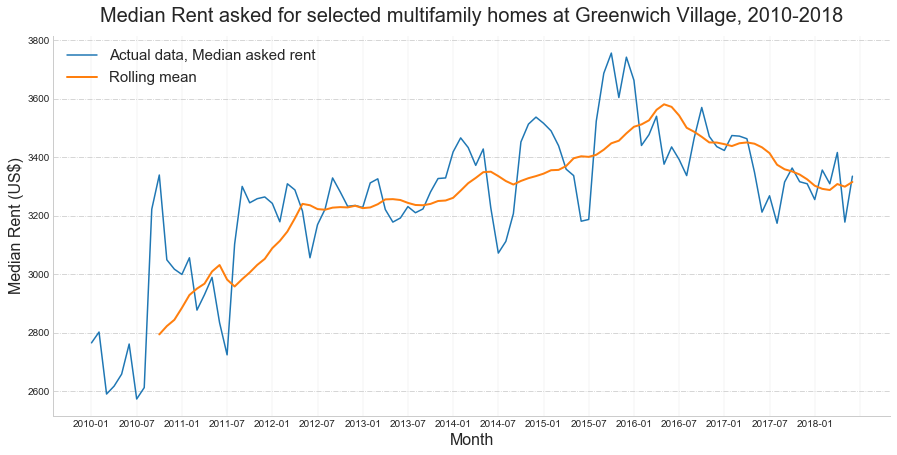

In [87]:
fig = pl.figure(figsize=(15,7))
ax = fig.add_subplot(111)

ax.plot(GW_allrent.iloc[:,:1], label='Actual data, Median asked rent')
ax.plot(GWrent_roll_df.iloc[:,:1], label="Rolling mean", lw=2)
ax.set_title("Median Rent asked for selected multifamily homes at Greenwich Village, 2010-2018",
            fontsize=20, y=1.02)
ax.set_ylabel('Median Rent (US$)', fontsize=16)
ax.set_xlabel('Month', fontsize=16)

ax.grid(axis='y', linestyle='-.')
ax.grid(axis='x', lw=.2);
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.xaxis.set_major_locator(plt.MaxNLocator(20))
ax.legend(fontsize=15)

### Fig.3 Median asking rent for multifamily homes at Greenwich Village, Manhattan, NYC, 2010/01-2018/06, studios+1-br only (weighted average), and smoothed line of the data using rolling mean of 10 entrees. 
The rolling mean line assures that the Greenwich Village rentals for 1-br and studios housing market grew from mid-2010 to the begining of 2016, then decreasing to this date. The rent ranges between 2,600 US Dollars, through maximum of ~ 3,600 US Dollars and gets to about 3,300 US Dollars in June 2018. Stationarity test is needed.

In [97]:
stationary = []
notstationary = []

print("AD Fuller test result for Greenwich Village rented studios+1-br homes' median asking rent time series:")

for i in range(len(GW_allrent.columns)):
    stationarytest = sm.tsa.adfuller(GW_allrent.iloc[:,i])
    if (stationarytest[0] > stationarytest[4]['5%']):
        print(" >> The time series is not stationary")
    else:
        print(" >> The time series is stationary")       

AD Fuller test result for Greenwich Village rented studios+1-br homes' median asking rent time series:
 >> The time series is not stationary


### The AD Fuller test for defining stationarity assured what was observed earlier and infered that the time serie is not stationary.
In further analysis I would try to find periodicity, although I might find  that older data is needed.

---

# 3. Building a housing/co-living rent ratio based on office/co-working rent ratio

### Approach: 
Lacking longitudinal data on co-housing, generally and in Greenwich Village in particular, the ratio of Office VS co-working equivalent space was used as a proxy for assessing the rent ratio between co-living bedroom and its equivalent classic housing type (1-br and studios). 

### Scope and Assumptions:
- Searched online for **450 sf office space** in Greenwich Village >> **_about 3,700 US Dollars_**.
- Compared the above to **WeWork private office for 3 ppl** in the two closest locations to Greenwich Village: [154 W 14th st](https://www.wework.com/buildings/154-w-14th--new-york-city--NY) and [Irving-place](https://www.wework.com/buildings/irving-place--new-york-city--NY). 
- I assume the same ratio should be applied to calculate bedroom in co-living space equivalent to its rental housing type (1-br and studios) >> average of **_2,785 US Dollars_**.
- **The office/co-working rent ratio in Greenwich Village is therefore `2,785 / 3,700 == 0.75`**.
- Having relatively few shared amenities per bedroom in our project, after applying the above ratio there will need to be additional adjustment of the price per bedroom.

-----
# 4. Multivariate linear regression analysis of census data to predict _median rent_
using census data in order to predict change in median rents. 

4.1 Exploring the data and its relations using scatter plot and pairplots:

/anaconda3/lib/python3.5/site-packages/ipykernel_launcher.py:1: FutureWarning: 'pandas.tools.plotting.scatter_matrix' is deprecated, import 'pandas.plotting.scatter_matrix' instead.
  """Entry point for launching an IPython kernel.


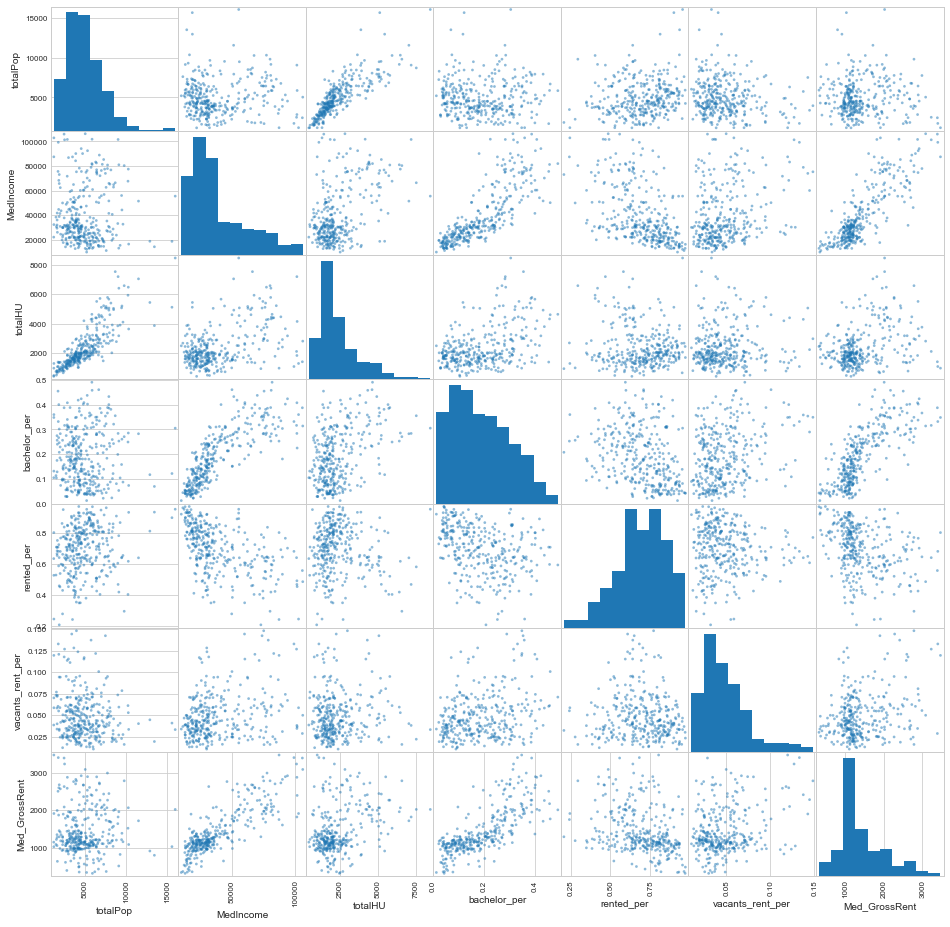

In [95]:
scatter_matrix (data16, s=30, figsize=(16, 16));

### Fig.4: A scatter matrix of all the data, showing correlations between variables.
Obvious correlations such as income and % of bachelor degree holders are observed. For the target variable, the scatter plot suggests of possible correlation between % of bachelor degree holders and the Median gross rent, % of rented housing units (negative, seem to be non-linear correlation) and of course income and rent.

** Population density is a better factor to analyse, compared to total population.

I will pairplot each regressor with the target variable, including confidence level:

No handles with labels found to put in legend.


<Figure size 1440x576 with 0 Axes>

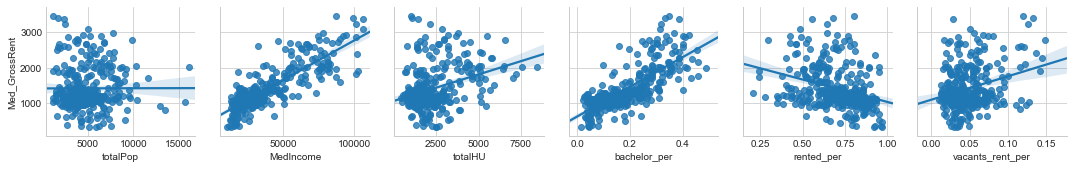

In [15]:
pl.figure(figsize = (20,8))

sns.pairplot(x_vars=data16.columns[:-1], y_vars='Med_GrossRent', 
             data=data16, kind="reg")
sns.set_style("whitegrid")
pl.legend(fontsize=16)

### Fig.5 Scatter pair-plots of regressors to be used in the multivariate regression
Most variables show some correlation with Median Gross rent. Multivariate regression will clarify more how well each regressor can linearily explain Median Gross Rent.

## 4.2 Create a model to predict Median asked rent, based on census data that returns  parameter of model quality + feature importance rank of the model + features statistical significance. 

I will split my data to train set and test set in order to validate my model's predictive power. The test set would be 30% of the data.

In [160]:
print(data16.shape)
data16.head()

(327, 7)


,totalPop,MedIncome,totalHU,bachelor_per,rented_per,vacants_rent_per,Med_GrossRent
0,6056,17848,2049,0.034841,0.812592,0.030747,601.5
1,9131,13258,3190,0.053773,0.782759,0.026959,518.5
2,6021,13915,2151,0.040525,0.855881,0.049744,685.5
3,5181,18604,1666,0.041112,0.823529,0.013205,1270.0
4,5687,15040,2038,0.036223,0.881256,0.035819,1043.0


In [161]:
data16['train'] = np.random.choice([0, 1], size=(327,), p=[1./3, 2./3])
print(data16.shape)
data16.head()

(327, 8)


,totalPop,MedIncome,totalHU,bachelor_per,rented_per,vacants_rent_per,Med_GrossRent,train
0,6056,17848,2049,0.034841,0.812592,0.030747,601.5,1
1,9131,13258,3190,0.053773,0.782759,0.026959,518.5,1
2,6021,13915,2151,0.040525,0.855881,0.049744,685.5,0
3,5181,18604,1666,0.041112,0.823529,0.013205,1270.0,0
4,5687,15040,2038,0.036223,0.881256,0.035819,1043.0,1


In [165]:
data16_train = data16[data16['train'] == 1].iloc[:,:-1]

print(data16_train.shape)
data16_train.head()

(216, 7)


,totalPop,MedIncome,totalHU,bachelor_per,rented_per,vacants_rent_per,Med_GrossRent
0,6056,17848,2049,0.034841,0.812592,0.030747,601.5
1,9131,13258,3190,0.053773,0.782759,0.026959,518.5
4,5687,15040,2038,0.036223,0.881256,0.035819,1043.0
6,3266,14813,1442,0.070116,0.760749,0.046463,1037.0
9,6198,18664,2269,0.039690,0.817981,0.025562,364.5


In [166]:
# Use statsmodels to regress y over x1 and x2, provide the r-squared and coefficients
lm1 = smf.ols(formula = 'Med_GrossRent ~ totalPop + MedIncome +'\
                        'totalHU + bachelor_per + rented_per + vacants_rent_per', 
                        data = data16_train).fit()
print('R2 = %f'%lm1.rsquared)
print(lm1.params)

R2 = 0.736945
Intercept             35.512941
totalPop               0.059321
MedIncome              0.023048
totalHU               -0.153566
bachelor_per        1329.457036
rented_per           436.015247
vacants_rent_per     564.305089
dtype: float64


In [167]:
lm1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          Med_GrossRent   R-squared:                       0.737
Model:                            OLS   Adj. R-squared:                  0.729
Method:                 Least Squares   F-statistic:                     97.59
Date:                Fri, 17 Aug 2018   Prob (F-statistic):           7.62e-58
Time:                        12:47:29   Log-Likelihood:                -1547.9
No. Observations:                 216   AIC:                             3110.
Df Residuals:                     209   BIC:                             3133.
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept           35.5129    154.801      0.229      0.819    -269.659     340.685
totalPop             0.0593      0.024      2.473      0.014       0.012       0.107
MedIncome            0.0230      0.002     12.139      0.000       0.019       0.027
totalHU             -0.1536      0.045     -3.447      0.001      -0.241      -0.066
bachelor_per      1329.4570    364.377      3.649      0.000     611.133    2047.781
rented_per         436.0152    175.371      2.486      0.014      90.293     781.737
vacants_rent_per   564.3051    890.101      0.634      0.527   -1190.421    2319.031
==============================================================================
Omnibus:                       25.246   Durbin-Watson:                   1.778
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               41.848
Skew:                           0.652   Prob(JB):                     8.18e-10
Kurtosis:                       4.717   Cond. No.                     1.85e+06
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.85e+06. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

### Summary of Multivariate linear model for train set; R2 == 0.737
The model explains 74% of the variance of Median Gross Rent. % of bachelor degree holders has the highest importance between the features, followed by % of rented housing units. 

I will validate the model with the rest of the data, left in the test set: 

In [168]:
# test set
data16_test = data16[data16['train'] == 0].iloc[:,:-1]

print(data16_test.shape)
data16_test.head()

(111, 7)


,totalPop,MedIncome,totalHU,bachelor_per,rented_per,vacants_rent_per,Med_GrossRent
2,6021,13915,2151,0.040525,0.855881,0.049744,685.5
3,5181,18604,1666,0.041112,0.823529,0.013205,1270.0
5,2614,14327,1022,0.030222,0.762231,0.049902,615.5
7,3701,22269,1445,0.105377,0.594464,0.042907,993.5
8,5975,22329,1892,0.076318,0.739958,0.013214,1053.5


In [171]:
rent_pred = lm1.predict(data16_test.iloc[:,:-1])

rent_pred[:20]

2      838.208124
3      936.986998
5      764.531561
7      969.924341
8     1045.608680
14     949.741004
15    1148.257807
19     944.269522
20     844.100788
21    1204.708669
25    1394.153790
26    1114.318958
27    2067.315753
31    1005.713062
36    1140.238490
37     868.107794
46    1314.097826
53    1273.062708
60    1394.193992
61    1816.811658
dtype: float64

In [173]:
residuals = data16_test['Med_GrossRent'] - rent_pred
rss = np.sum(residuals**2)
MSE = rss/(lm1.nobs-2)

In [175]:
rss

10388802.895120721

In [176]:
MSE

48545.80792112486

In order to determine whether a significant factor was left out of the model I will plot the residuals over a zero error line:

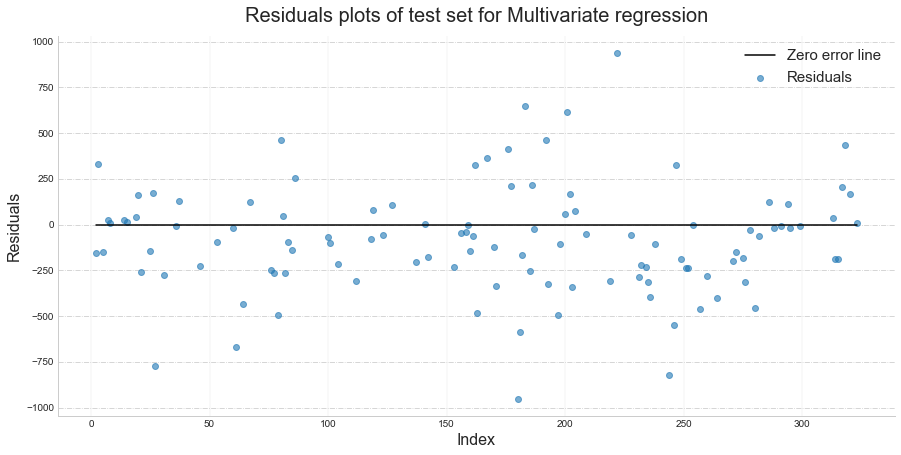

In [193]:
fig = pl.figure(figsize=(15,7))
ax = fig.add_subplot(111)

ax.scatter(data16_test.index, residuals, label='Residuals', alpha=.6)
horiz_line_data = np.array([0 for i in range(len(data16_test.index))])
ax.plot(data16_test.index, horiz_line_data, 'k',  label='Zero error line') 
# ax.plot((0.0, 111.0), (0.0,0.0), label="XXXXX mean", lw=2, color='k')
ax.set_title("Residuals plots of test set for Multivariate regression",
            fontsize=20, y=1.02)
ax.set_ylabel('Residuals', fontsize=16)
ax.set_xlabel('Index', fontsize=16)

ax.grid(axis='y', linestyle='-.')
ax.grid(axis='x', lw=.2);
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.legend(fontsize=15)

### Fig.6 Residuals plot of the test set for Multivariate linear regression predicting Median Gross Rent
The residuals seem to be randomly distributed around the zero error line, which imply for a good performance of the model. There is no underlying trend in the data to suggest a major factor is missing from the model. Most of the errors fall into the range of **500 US Dollars**; depanding on the application of the model, this could be good enough or require more tightning of the model. 


## In order to use the model to predict median gross rent of census tracts I would make a prediction of the change of the regressors, based on historical data. That will create the assumed future values for the independent variables and to use them to predict the target variable future values.

----
# 5. Revenue Prediction

- The last inventory (June 2018) of the median asking rent for comparable rental housing types in Greenwich Village was **3,335 US Dollars**.
- Listing data: **August 2018**
- August 2018 median rent to be asked for a comparable rental housing types in Greenwich Village, continuing the trend that shows some recovery from the decrease in rent == **3,460 US Dollars**
- First rent to be asked for a bedroom in co-living project in Greenwich Village, applying the **75%** ratio of office-co-working rents in this area == **3,460 * 0.75 = 2,595 US Dollars**
- Decreasing the rent due to low amenities per bedroom in our project: reduce 10% >> rent to be asked for a bedroom in the 27 W 11 co-living == **2,595 * 0.9  == 2,335 US Dollars**.
- Number of bedrooms: **77**
- Vacancy rate assumed == **90%** >> **69 rooms will be rented**.

## First month revenue from the project is predicted to be 69 bedrooms * 2,335 US Dollars per bedroom == _161,115 US Dollars_.

- I assume the co-living trend will develop as developed the co-working trend prior it; in a deeper analysis I would make a time series analysis of the first 5years of co-working and would assume that co-living market will grow following the co-working market growth's line.
- Therefore, I would assume that in the first 5 years, the co-living median asking rent growth line will follow this of co-working in its beginning, then will continue to behave as its equivalent housing market type in the neighbourhood. 

# Risks and Analysis limitations

Several risks are important to being taken into consideration:
- Co-housing has yet to be fully embraced by banks / municipalities and could face regulations and / or bans (such as Airbnb).
- The rate of bedroom-bathrooms and bedroom-kitchen of this project is lower than most of the existing NYC co-living projects, ranged from **private bathrooms to 2 bathrooms for every 3 bedrooms**  (examples: [Ollie floor plans](https://altalic.com/wp-content/uploads/2018/08/ALTA-by-Ollie-804.png), [COMMON floor plans](http://cdn.brownstoner.com/wp-content/uploads/2015/10/Common-1162-Cellar1st-2nd-Floor-Construction-Plans-e1445273623967.jpg); NYC), compared to the 27 W 11 st project ratio of **2 bathroom for every 7 bedrooms**. This might negatively affect the demand for the bedrooms.
- Recession in housing might occur within the next 15 years; in a further research I would suggest 3 scenarios of base market, boom, and recession, giving probability of 50%-25%-25% for each, respectively.
- 

----

# Future Research
In a future research, I would analyse the **rent per sf per month (rent/sf/mo)** in order to get more accurate result and more planning flexibility in allocating amenities to different types of residential units.<br>
Additionally, I would use more data in my time series analysis, adding data from similar cities that are also facing the rapid emergence of co-housing, such as SF, Washington DC, Boston, etc; and/or places that are approximate to universities.<br>
Moreover, I would make a more thorough validation of the multivariate model, reducing multicollinearity such as between income and % of bachelor degree holders.
Finally, as the project site is close to NYU, I would consider to use data of the total number of students in order to strengthen my assumptions regarding the demand for co-housing of the highly-targeted social group.